In [ ]:
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 57.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from collections import Counter
import spacy

nlp = spacy.load("pt_core_news_sm")
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
files = [
    "consulta_cand_2024_BRASIL.csv",
    "bem_candidato_2024_BRASIL.csv",
    "consulta_cand_complementar_2024_BRASIL.csv",
    "rede_social_candidato_2024_BRASIL.csv",
    "consulta_coligacao_2024_BRASIL.csv",
    "motivo_cassacao_2024_BRASIL.csv"
]

for file in files:
    try:
        data = load_data(file)
        print(f"\nColunas no arquivo '{file}':")
        print(data.columns.tolist())
    except Exception as e:
        print(f"Erro ao carregar {file}: {e}")


Colunas no arquivo 'consulta_cand_2024_BRASIL.csv':
['DT_GERACAO', 'HH_GERACAO', 'ANO_ELEICAO', 'CD_TIPO_ELEICAO', 'NM_TIPO_ELEICAO', 'NR_TURNO', 'CD_ELEICAO', 'DS_ELEICAO', 'DT_ELEICAO', 'TP_ABRANGENCIA', 'SG_UF', 'SG_UE', 'NM_UE', 'CD_CARGO', 'DS_CARGO', 'SQ_CANDIDATO', 'NR_CANDIDATO', 'NM_CANDIDATO', 'NM_URNA_CANDIDATO', 'NM_SOCIAL_CANDIDATO', 'NR_CPF_CANDIDATO', 'DS_EMAIL', 'CD_SITUACAO_CANDIDATURA', 'DS_SITUACAO_CANDIDATURA', 'TP_AGREMIACAO', 'NR_PARTIDO', 'SG_PARTIDO', 'NM_PARTIDO', 'NR_FEDERACAO', 'NM_FEDERACAO', 'SG_FEDERACAO', 'DS_COMPOSICAO_FEDERACAO', 'SQ_COLIGACAO', 'NM_COLIGACAO', 'DS_COMPOSICAO_COLIGACAO', 'SG_UF_NASCIMENTO', 'DT_NASCIMENTO', 'NR_TITULO_ELEITORAL_CANDIDATO', 'CD_GENERO', 'DS_GENERO', 'CD_GRAU_INSTRUCAO', 'DS_GRAU_INSTRUCAO', 'CD_ESTADO_CIVIL', 'DS_ESTADO_CIVIL', 'CD_COR_RACA', 'DS_COR_RACA', 'CD_OCUPACAO', 'DS_OCUPACAO', 'CD_SIT_TOT_TURNO', 'DS_SIT_TOT_TURNO']

Colunas no arquivo 'bem_candidato_2024_BRASIL.csv':
['DT_GERACAO', 'HH_GERACAO', 'ANO_ELEICAO'

In [ ]:
def load_data(filename):
    return pd.read_csv(filename, encoding='latin1', delimiter=';', quotechar='"').replace({
        "#NULO": None, "#NE": None, -1: None, -3: None
    })

cand_data = load_data("consulta_cand_2024_BRASIL.csv")
bem_data = load_data("bem_candidato_2024_BRASIL.csv")
coligacao_data = load_data("consulta_coligacao_2024_BRASIL.csv")

In [ ]:
cand_data = load_data("consulta_cand_2024_BRASIL.csv")
bem_data = load_data("bem_candidato_2024_BRASIL.csv")

prefeitos_2020 = cand_data[(cand_data['DS_CARGO'] == 'Prefeito') & (cand_data['DS_SITUACAO_CANDIDATURA'] == 'DEFERIDO')]

bens_prefeitos = bem_data[bem_data['SQ_CANDIDATO'].isin(prefeitos_2020['SQ_CANDIDATO'])]
bens_prefeitos['VR_BEM_CANDIDATO'] = pd.to_numeric(bens_prefeitos['VR_BEM_CANDIDATO'], errors='coerce').fillna(0)

if bens_prefeitos['VR_BEM_CANDIDATO'].sum() == 0:
    print("Todos os valores em VR_BEM_CANDIDATO são zero ou inválidos.")
else:
    bens_total = bens_prefeitos.groupby('SQ_CANDIDATO')['VR_BEM_CANDIDATO'].sum().reset_index()
    top_prefeito = bens_total.loc[bens_total['VR_BEM_CANDIDATO'].idxmax()]
    top_prefeito_info = prefeitos_2020[prefeitos_2020['SQ_CANDIDATO'] == top_prefeito['SQ_CANDIDATO']]
    print(top_prefeito_info[['NM_CANDIDATO', 'SG_UF', 'VR_BEM_CANDIDATO']])


Todos os valores em VR_BEM_CANDIDATO são zero ou inválidos.


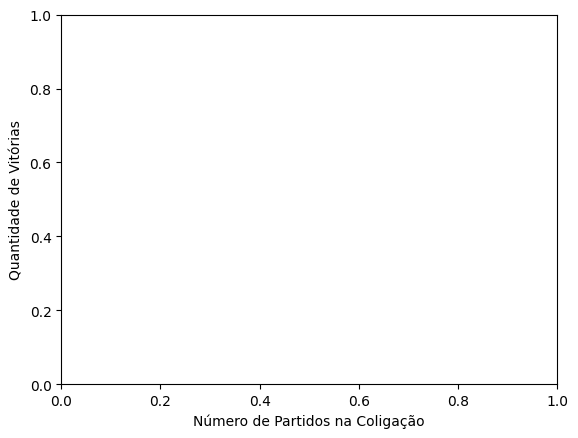

In [ ]:
coligacao_data = load_data("consulta_coligacao_2024_BRASIL.csv")

coligacao_data['NR_PARTIDOS'] = coligacao_data['DS_COMPOSICAO_COLIGACAO'].str.split('/').apply(len)
vencedores = cand_data[cand_data['DS_SITUACAO_CANDIDATURA'] == 'DEFERIDO']
resultados_coligacao = coligacao_data.merge(vencedores, on=['CD_ELEICAO', 'SG_UF'], suffixes=('_colig', '_cand'))

coligacao_count = resultados_coligacao.groupby('NR_PARTIDOS').size().reset_index(name='Vitorias')
sns.barplot(x='NR_PARTIDOS', y='Vitorias', data=coligacao_count)
plt.xlabel("Número de Partidos na Coligação")
plt.ylabel("Quantidade de Vitórias")
plt.show()

In [ ]:
candidatos_por_partido_uf = cand_data.groupby(['SG_PARTIDO', 'SG_UF']).size().reset_index(name='Quantidade')
candidatos_por_partido_uf = candidatos_por_partido_uf.sort_values('Quantidade', ascending=False)
print(candidatos_por_partido_uf.head())

       SG_PARTIDO SG_UF  Quantidade
434           PSD    SP        7118
266            PL    SP        6823
608  REPUBLICANOS    SP        6763
419           PSD    MG        6292
123           MDB    SP        6245


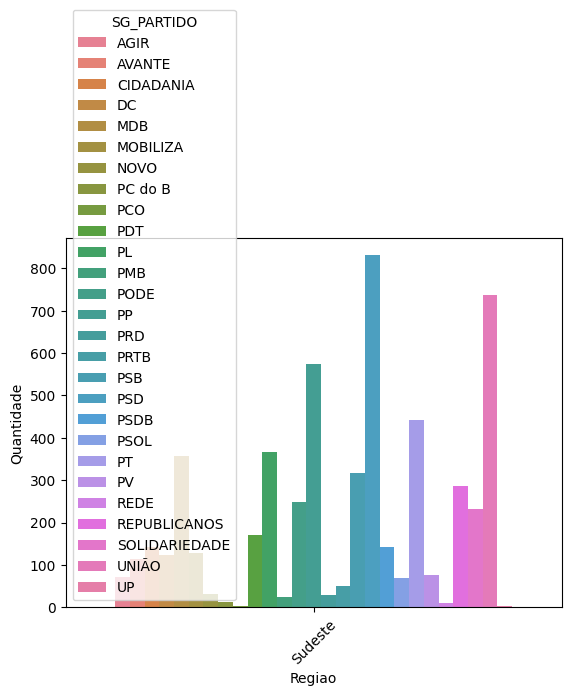

In [ ]:
cand_data['Regiao'] = cand_data['SG_UF'].map({
    'N': 'Norte', 'NE': 'Nordeste', 'SE': 'Sudeste', 'S': 'Sul', 'CO': 'Centro-Oeste'
})
candidatos_regional = cand_data.groupby(['SG_PARTIDO', 'Regiao']).size().reset_index(name='Quantidade')

sns.barplot(x='Regiao', y='Quantidade', hue='SG_PARTIDO', data=candidatos_regional)
plt.xticks(rotation=45)
plt.show()

In [ ]:
cargos_relevantes = cand_data[cand_data['DS_CARGO'].isin(['Prefeito', 'Vice-Prefeito', 'Vereador'])]
partidos_uf = cargos_relevantes.groupby(['SG_PARTIDO', 'SG_UF']).size().reset_index(name='Total')

maiores_partidos_uf = partidos_uf.loc[partidos_uf.groupby('SG_UF')['Total'].idxmax()]
print(maiores_partidos_uf)

Empty DataFrame
Columns: [SG_PARTIDO, SG_UF, Total]
Index: []


In [ ]:
cand_comp_data = load_data("consulta_cand_complementar_2024_BRASIL.csv")
indigenas_quilombolas = cand_comp_data[(cand_comp_data['ST_QUILOMBOLA'] == 'S') | (cand_comp_data['CD_ETNIA_INDIGENA'].notna())]

cand_data['Regiao'] = cand_data['SG_UF'].map({
    'AC': 'Norte', 'AL': 'Nordeste', 'AM': 'Norte', 'AP': 'Norte', 'BA': 'Nordeste',
    'CE': 'Nordeste', 'DF': 'Centro-Oeste', 'ES': 'Sudeste', 'GO': 'Centro-Oeste',
    'MA': 'Nordeste', 'MG': 'Sudeste', 'MS': 'Centro-Oeste', 'MT': 'Centro-Oeste',
    'PA': 'Norte', 'PB': 'Nordeste', 'PE': 'Nordeste', 'PI': 'Nordeste',
    'PR': 'Sul', 'RJ': 'Sudeste', 'RN': 'Nordeste', 'RO': 'Norte', 'RR': 'Norte',
    'RS': 'Sul', 'SC': 'Sul', 'SE': 'Nordeste', 'SP': 'Sudeste', 'TO': 'Norte'
})

region_count = indigenas_quilombolas.merge(cand_data[['SQ_CANDIDATO', 'Regiao']], on='SQ_CANDIDATO')
region_count = region_count['Regiao'].value_counts()
print(region_count)

Regiao
Sudeste         69195
Nordeste        42403
Sul             28820
Norte           16433
Centro-Oeste    13265
Name: count, dtype: int64


In [ ]:
redes = load_data("rede_social_candidato_2024_BRASIL.csv")

rede_popular = redes.groupby(['SG_UF', 'DS_URL']).size().reset_index(name='Frequencia')
rede_popular = rede_popular.sort_values('Frequencia', ascending=False).drop_duplicates('SG_UF')
print(rede_popular[['SG_UF', 'DS_URL', 'Frequencia']])

       SG_UF                                             DS_URL  Frequencia
89658     MG                         https://www.instagram.com/         104
366076    SP                         https://www.instagram.com/          91
170797    PR                              https://instagram.com          62
13226     BA                          https://www.instagram.com          54
132290    PA                               https://facebook.com          39
39389     ES           https://www.compromissocomibiracu.com.br          38
122566    MT                          https://web.whatsapp.com/          30
24011     CE                          https://flavinho15.can.br          28
315529    SC                          https://www.instagram.com          25
153105    PE  https://url_informada_em_petição_nos_autos_exc...          25
259650    RS                               https://facebook.com          25
147756    PB     https://www.facebook.com/marcelo.vieiracosta.3          20
251006    RO

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='portuguese')
propostas_por_uf = df_cand.groupby('SG_UF')['PROPOSTAS'].apply(lambda x: ' '.join(x.dropna()))
tfidf_matrix = vectorizer.fit_transform(propostas_por_uf)
print(vectorizer.get_feature_names_out())


In [ ]:
import folium

mapa_brasil = folium.Map(location=[-15.7801, -47.9292], zoom_start=4)
folium.Marker(location=[-15.7801, -47.9292], popup="Exemplo", icon=folium.Icon(color="blue")).add_to(mapa_brasil)
mapa_brasil.save('mapa_eleicoes_2020.html')
